#**Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей**

**Цель лабораторной работы**\
Изучение способов подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.

**Задание**

1.   Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2.   С использованием метода train_test_split разделите выборку на обучающую и тестовую.
3.   Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью подходящих для задачи метрик.
4.   Произведите подбор гиперпараметра K с использованием GridSearchCV и/или RandomizedSearchCV и кросс-валидации, оцените качество оптимальной модели. Желательно использование нескольких стратегий кросс-валидации.
5.   Сравните метрики качества исходной и оптимальной моделей.



##**Решение**

###**Импорт библиотек и загрузка данных**

In [11]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from google.colab import files
%matplotlib inline 
sns.set(style="ticks")

In [2]:
# загрузка данных
uploaded = files.upload()

Saving winequality-red.csv to winequality-red.csv


In [3]:
data = pd.read_csv('winequality-red.csv', sep=',')

###**Характеристики датасета**

В лабораторной работе используется датасет Red Wine Quality, который содержит химические характеристики разновидностей португальского вина "Vinho Verde", а также рейтинг вина, исходя из его характеристик.\
**В датасете представлены следующие признаки:**


*   fixed acidity - винная кислота, наиболее сильная и самая объёмная, присутствующая в виноградных винах, в значительной степени влияет на эффективную кислотность (pH) этих вин.
*   volatile acidity - количество уксусной кислоты в вине, при больших содержаниях может привести к неприятному уксусному вкусу.
*   citric acid - лимонная кислота в небольшом количестве может добавить свежести и аромату вину.
*   residual sugar - количество сахара, которое остается после окончания брожения, большинство вин содержат хотя бы 1 гр/л, а вина с содержанием сахара больше 45 гр/л считаются сладкими.
*   chlorides - количество солей в вине
*   free sulfur dioxide - свободная форма SO2, существующая в равновесном состоянии между молекулярным SO2 (как растворенный газ) и бисульфит-ионом; она предотвращает развитие микробов и окисление вина
*   total sulfur dioxide - количество свободного и связанного S02; в низких концентрациях, почти незаметен в вине, но при концентрации сбодной формы больше 50 ppm, может отразиться на вкусе вина
*   density - плотность воды, зависящая от процента алкогоголя и сахара
*   pH - водородный показатель, мера силы и концентрации диссоциированных кислот в растворе. Показатель варьируется от 0 (очень кислотный) до 14 (очень щелочной); большинство вин находятся в диапозоне 3-4 по pH шкале
*   sulphates - винная добавка,может повлиять на уровни диоксида сера (SO2), который выступает в роле антиоксиданта
*   alcohol - объёма растворённого безводного спирта к объёму всего вина в процентах
*   quality - оценка качества вина, рейтинг в диапозоне от 0 до 10.



In [4]:
# размер датасета
data.shape

(1599, 12)

In [5]:
# типы колонок
data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [6]:
# первые 5 строк
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [8]:
# статистические характеристики признаков
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


###**Разделение выборки на обучающую и тестовую с использованием метода train_test_split**

In [13]:
# выделим входные признаки
data_X = data.iloc[:, :-1].values
data_X

array([[ 7.4  ,  0.7  ,  0.   , ...,  3.51 ,  0.56 ,  9.4  ],
       [ 7.8  ,  0.88 ,  0.   , ...,  3.2  ,  0.68 ,  9.8  ],
       [ 7.8  ,  0.76 ,  0.04 , ...,  3.26 ,  0.65 ,  9.8  ],
       ...,
       [ 6.3  ,  0.51 ,  0.13 , ...,  3.42 ,  0.75 , 11.   ],
       [ 5.9  ,  0.645,  0.12 , ...,  3.57 ,  0.71 , 10.2  ],
       [ 6.   ,  0.31 ,  0.47 , ...,  3.39 ,  0.66 , 11.   ]])

In [17]:
# выделяем целевой признак
data_Y = data.iloc[:, -1].values
data_Y

array([5, 5, 5, ..., 6, 5, 6])

In [50]:
# преобразуем целевой признак в бинарный {>5(1), <=5(0)}
data_Y=(data_Y>5).astype(int)
data_Y

array([0, 0, 0, ..., 1, 0, 1])

In [51]:
X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_Y, test_size=0.25, random_state=1)

In [52]:
# размер обучающей выборки
X_train.shape, Y_train.shape

((1199, 11), (1199,))

In [53]:
# размер тестовой выборки
X_test.shape, Y_test.shape

((400, 11), (400,))

In [54]:
np.unique(Y_train)

array([0, 1])

In [55]:
np.unique(Y_test)

array([0, 1])

In [28]:
def class_proportions(array: np.ndarray) -> Dict[int, Tuple[int, float]]:
    """
    Вычисляет пропорции классов
    array - массив, содержащий метки классов
    """
    # Получение меток классов и количества меток каждого класса 
    labels, counts = np.unique(array, return_counts=True)
    # Превращаем количество меток в процент их встречаемости
    # делим количество меток каждого класса на общее количество меток
    counts_perc = counts/array.size
    # Теперь sum(counts_perc)==1.0
    # Создаем результирующий словарь,
    # ключом словаря явлется метка класса, 
    # а значением словаря процент встречаемости метки
    res = dict()
    for label, count2 in zip(labels, zip(counts, counts_perc)):
        res[label] = count2
    return res

def print_class_proportions(array: np.ndarray):
    """
    Вывод пропорций классов
    """
    proportions = class_proportions(array)
    if len(proportions)>0:
        print('Метка \t Количество \t Процент встречаемости')
    for i in proportions:
        val, val_perc = proportions[i]
        val_perc_100 = round(val_perc * 100, 2)
        print('{} \t {} \t \t {}%'.format(i, val, val_perc_100))

In [56]:
print_class_proportions(data_Y)

Метка 	 Количество 	 Процент встречаемости
0 	 744 	 	 46.53%
1 	 855 	 	 53.47%


In [57]:
# для обучающей выборки
print_class_proportions(Y_train)

Метка 	 Количество 	 Процент встречаемости
0 	 556 	 	 46.37%
1 	 643 	 	 53.63%


In [58]:
# для тестовой выборки
print_class_proportions(Y_test)

Метка 	 Количество 	 Процент встречаемости
0 	 188 	 	 47.0%
1 	 212 	 	 53.0%


###**Обучение модели ближайших соседей для произвольно заданного гиперпараметра К и оценка качества**

In [59]:
# строим модель 5 ближайших соседей
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(X_train, Y_train)
target_train = knn_5.predict(X_train)
target_test = knn_5.predict(X_test)

In [37]:
# Функция вывода метрики Accuracy для каждого класса признака
from typing import Dict
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [60]:
# вывод метрики Accuracy для каждого класса целевого признака
print_accuracy_score_for_classes(Y_test, target_test)

Метка 	 Accuracy
0 	 0.6542553191489362
1 	 0.6367924528301887


In [61]:
# Accuracy для обучающей и тестовой выборок
accuracy_score(Y_train, target_train), accuracy_score(Y_test, target_test)

(0.7689741451209341, 0.645)

###**Построение модели и кросс-валидация**

In [62]:
# словарь метрик качества классификации 
scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}

In [63]:
# проводим кросс-валидацию для 5nn
scores = cross_validate(KNeighborsClassifier(n_neighbors=5), 
                        data_X, data_Y, scoring=scoring, 
                        cv=5, return_train_score=True)
scores

{'fit_time': array([0.00644422, 0.00172877, 0.00177383, 0.00174928, 0.00174737]),
 'score_time': array([0.0192132 , 0.01362848, 0.01426148, 0.01357317, 0.01345539]),
 'test_f1': array([0.63647599, 0.60134019, 0.61553822, 0.53595085, 0.5520879 ]),
 'test_precision': array([0.66105116, 0.60155351, 0.61546345, 0.54154627, 0.5521097 ]),
 'test_recall': array([0.640625  , 0.603125  , 0.615625  , 0.546875  , 0.55485893]),
 'train_f1': array([0.77500054, 0.76868139, 0.75463488, 0.78358712, 0.775     ]),
 'train_precision': array([0.77548398, 0.76888762, 0.75490694, 0.78402658, 0.775     ]),
 'train_recall': array([0.77482408, 0.76856919, 0.7544957 , 0.78342455, 0.775     ])}

Видно, что F1-мера выше на обучающей выборке, чем на тестовой.

###**Подбор гиперпараметра К с использованием GridSearchCV и кросс-валидации**

In [67]:
# создаем массив значения гиперпараметра - количества ближайших соседей
n_range = np.array(range(5,55,5))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}]

In [73]:
# производим подбор гиперпараметра, используя для оценки качества F1-меру
# и 5 фолдов для кросс-валидации
grid_search = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring=scoring['f1'])
grid_search.fit(X_train, Y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [74]:
# выводим результаты подбора
grid_search.cv_results_

{'mean_fit_time': array([0.0015779 , 0.00144563, 0.00130367, 0.00133181, 0.00131168,
        0.00133424, 0.00129809, 0.001299  , 0.00132165, 0.00131226]),
 'mean_score_time': array([0.01051316, 0.01090364, 0.01145554, 0.01117802, 0.01047411,
        0.01117377, 0.01094408, 0.0123003 , 0.01132913, 0.01139741]),
 'mean_test_score': array([0.63766519, 0.63369797, 0.65100592, 0.66585353, 0.65392624,
        0.65953263, 0.65840532, 0.65662492, 0.65723284, 0.6626067 ]),
 'param_n_neighbors': masked_array(data=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 5},
  {'n_neighbors': 10},
  {'n_neighbors': 15},
  {'n_neighbors': 20},
  {'n_neighbors': 25},
  {'n_neighbors': 30},
  {'n_neighbors': 35},
  {'n_neighbors': 40},
  {'n_neighbors': 45},
  {'n_neighbors': 50}],
 'rank_test_score': array([ 9, 10,  8,  1,  7, 

In [75]:
# лучшая модель
grid_search.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [76]:
# лучшее значение метрики
grid_search.best_score_

0.6658535324994627

In [77]:
# лучшее значение параметров
grid_search.best_params_

{'n_neighbors': 20}

###**Оценка и анализ качества итоговой модели**

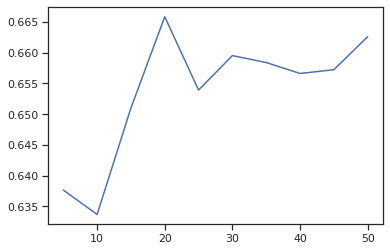

In [78]:
# изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, grid_search.cv_results_['mean_test_score'])

In [81]:
# обучение лучшей модели
grid_search.best_estimator_.fit(X_train, Y_train)
tuned_target_train = grid_search.best_estimator_.predict(X_train)
tuned_target_test = grid_search.best_estimator_.predict(X_test)

In [89]:
from sklearn.metrics import f1_score

In [90]:
# новое качество модели, F1-мера
f1_score(Y_train, tuned_target_train), f1_score(Y_test, tuned_target_test)

(0.7185244587008822, 0.6326530612244898)

In [91]:
# качество модели до подбора гиперпараметров, F1-мера
f1_score(Y_train, target_train), f1_score(Y_test, target_test)

(0.7834245504300233, 0.6553398058252428)

Как видно разница между показателями для тестовой и обучающей выборки сократилась с 0.13 до 0.08

###**Вывод**
В ходе лабораторной работы были изучены методы построения модели классификации с использованием кросс-валидации и подбора гиперпараметров, а также использованы различные метрики для оценки их качества.